In [1]:
# Cell 1: Import all required libraries
import base64
from io import BytesIO
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import json
import pandas as pd
import os

# Helper functions for image processing
def decode_base64_image(base64_string_or_list):
    if isinstance(base64_string_or_list, list):
        base64_string = base64_string_or_list[0]
    else:
        base64_string = base64_string_or_list
    
    try:
        img_data = base64.b64decode(base64_string.split(',')[1])
    except IndexError:
        img_data = base64.b64decode(base64_string)
    
    return Image.open(BytesIO(img_data))

def create_composite_image(images):
    if not images:
        return np.zeros((16, 16), dtype=np.uint8)
    np_images = [np.array(img.convert('L').resize((16, 16))) for img in images]
    mean_image = np.mean(np.stack(np_images), axis=0)
    return mean_image.astype(np.uint8)

In [2]:
# Cell 2: Load the JATOS results
def load_jatos_results(jrzip_path):
    all_results = []
    with zipfile.ZipFile(jrzip_path, 'r') as zip_ref:
        for file_name in zip_ref.namelist():
            if file_name.endswith('.txt'):
                with zip_ref.open(file_name) as f:
                    content = f.read().decode('utf-8')
                    for line in content.split('\n'):
                        if line.strip():
                            all_results.append(json.loads(line))
    return pd.DataFrame(all_results)

# Load your specific file
#jrzip_path = "jatos_results_20241202133153.jrzip" old just me and Guido
jrzip_path = "jatos_results_20241209144728.jrzip"
df = load_jatos_results(jrzip_path)

AttributeError: 'list' object has no attribute 'keys'


Analyzing Participant 4737


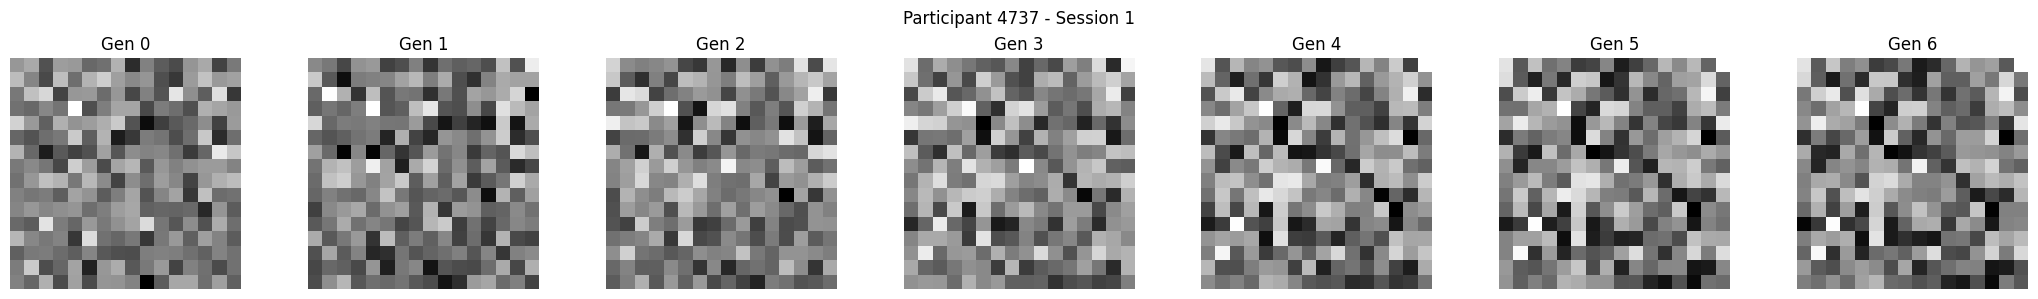

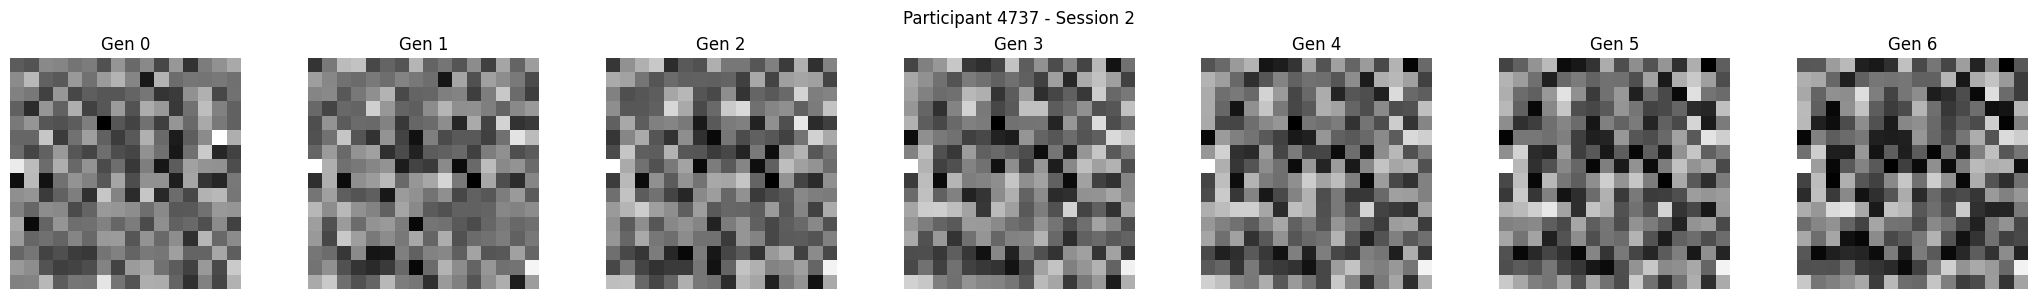


Analyzing Participant 4739


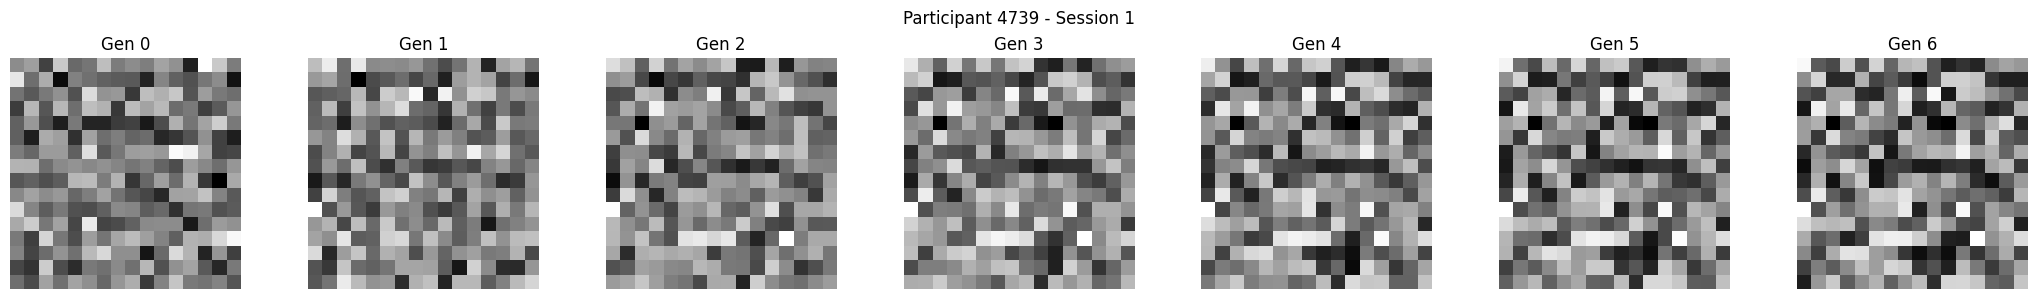

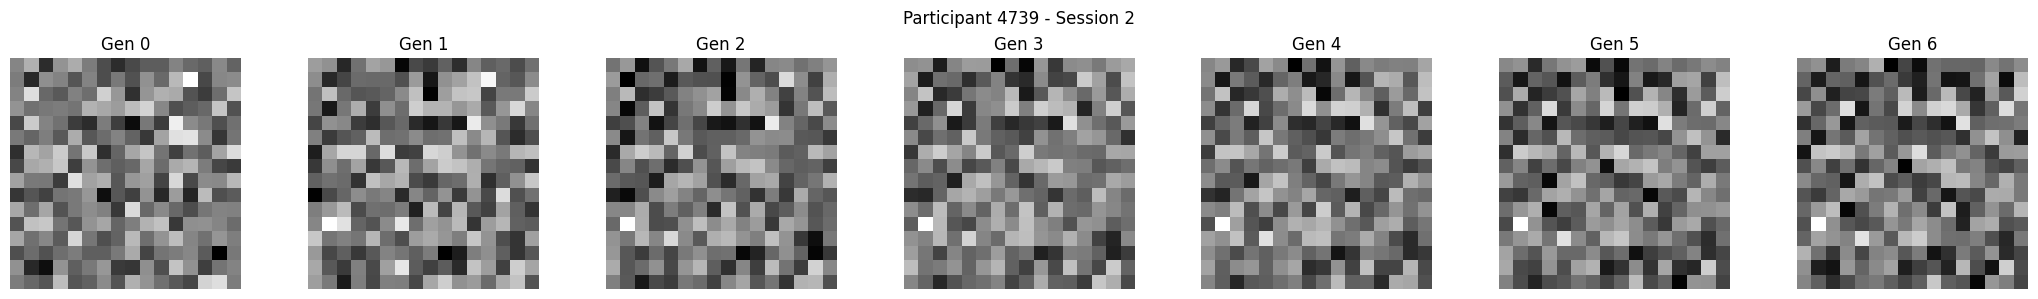

In [ ]:
# Cell 3: Create visualization function
def plot_participant_sessions(participant_data, participant_id):
    for session, session_data in participant_data.items():
        generations = sorted(session_data.keys())
        n_gens = len(generations)
        
        if n_gens == 0:
            print(f"No generations found for Participant {participant_id}, Session {session}")
            continue
            
        fig, axes = plt.subplots(1, n_gens, figsize=(3*n_gens, 3))
        if n_gens == 1:
            axes = [axes]
        
        for idx, gen in enumerate(generations):
            gen_images = []
            for img_base64 in session_data[gen]['selected']:
                try:
                    img = decode_base64_image(img_base64)
                    gen_images.append(img)
                except:
                    continue
                    
            if gen_images:
                composite = create_composite_image(gen_images)
                axes[idx].imshow(composite, cmap='gray')
                axes[idx].axis('off')
                axes[idx].set_title(f'Gen {gen}')
        
        plt.suptitle(f'Participant {participant_id} - Session {session}')
        plt.tight_layout()
        plt.show()
        plt.close()

# Process and organize data
def get_participant_session_data(df):
    results = {}
    
    for _, row in df.iterrows():
        if 'evolution_summary' in row:
            participant_id = row['metadata']['participant_id']
            if participant_id not in results:
                results[participant_id] = {}
            
            for gen_data in row['evolution_summary']:
                session = gen_data['session']
                if session not in results[participant_id]:
                    results[participant_id][session] = {}
                
                generation = gen_data['generation']
                if 'selected_parents' in gen_data:
                    results[participant_id][session][generation] = {
                        'selected': [p['filtered_image'] for p in gen_data['selected_parents']]
                    }
    
    return results

# Run the visualization
participant_data = get_participant_session_data(df)
for participant_id, data in participant_data.items():
    print(f"\nAnalyzing Participant {participant_id}")
    plot_participant_sessions(data, participant_id)

In [ ]:
# Cell 4: Save classification images
def save_classification_images(participant_data, output_dir="classification_images"):
    # Create main output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    # Create zip file
    zip_path = os.path.join(output_dir, "classification_images.zip")
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        
        for participant_id, sessions in participant_data.items():
            for session, generations in sessions.items():
                # Create directory path within zip
                session_dir = f"participant_{participant_id}/session_{session}"
                
                for gen, data in generations.items():
                    gen_images = []
                    for img_base64 in data['selected']:
                        try:
                            img = decode_base64_image(img_base64)
                            gen_images.append(img)
                        except:
                            continue
                    
                    if gen_images:
                        composite = create_composite_image(gen_images)
                        
                        # Save to bytes buffer
                        img_buffer = BytesIO()
                        Image.fromarray(composite).save(img_buffer, format='PNG', optimize=True)
                        img_buffer.seek(0)
                        
                        # Add to zip with proper path
                        zip_filename = f"{session_dir}/generation_{gen}_composite.png"
                        zipf.writestr(zip_filename, img_buffer.getvalue())
    
    print(f"Saved all classification images to {zip_path}")
    return zip_path

# Save the images
zip_file = save_classification_images(participant_data)

Saved all classification images to classification_images\classification_images.zip
